In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from optuna.samplers import GridSampler,RandomSampler
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score,roc_curve

Problem Statement: Crop Recommendation Using Soil and Weather Attributes

In [3]:
crop_data = pd.read_csv('data_sets/Crop_recommendation.csv')

In [4]:
crop_data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [5]:
crop_data.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [6]:
crop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [7]:
len(crop_data.label.unique())

22

In [8]:
crop_data.label = crop_data.label.astype('category')

In [9]:
crop_data.duplicated().sum()

0

In [10]:
crop_data.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [11]:
features_data = crop_data.drop(columns = "label")

In [12]:
features_data.tail()

,N,P,K,temperature,humidity,ph,rainfall
2195,107,34,32,26.774637,66.413269,6.780064,177.774507
2196,99,15,27,27.417112,56.636362,6.086922,127.924610
2197,118,33,30,24.131797,67.225123,6.362608,173.322839
2198,117,32,34,26.272418,52.127394,6.758793,127.175293
2199,104,18,30,23.603016,60.396475,6.779833,140.937041


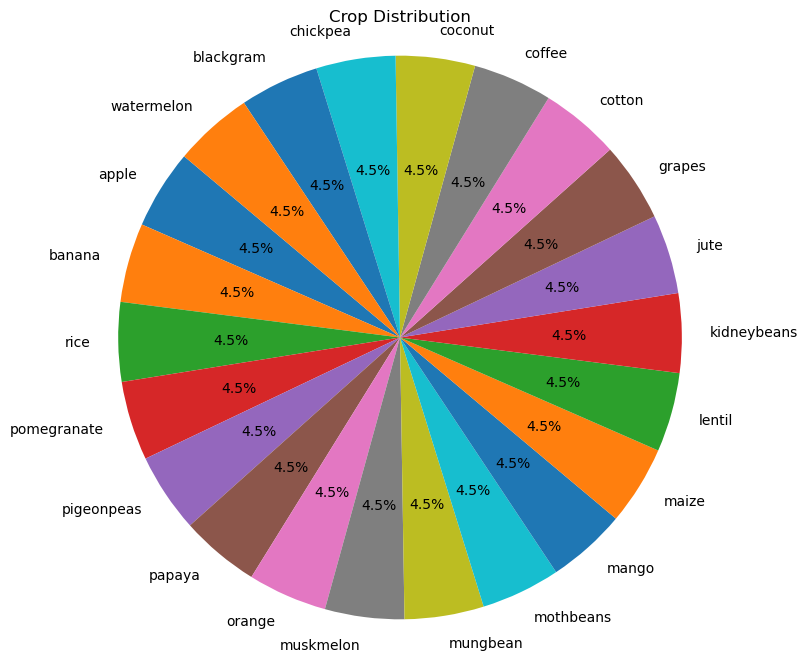

In [121]:
label_counts = crop_data['label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.savefig("pie.png", dpi=300, bbox_inches='tight')
plt.title('Crop Distribution')
plt.axis('equal')  
plt.show()

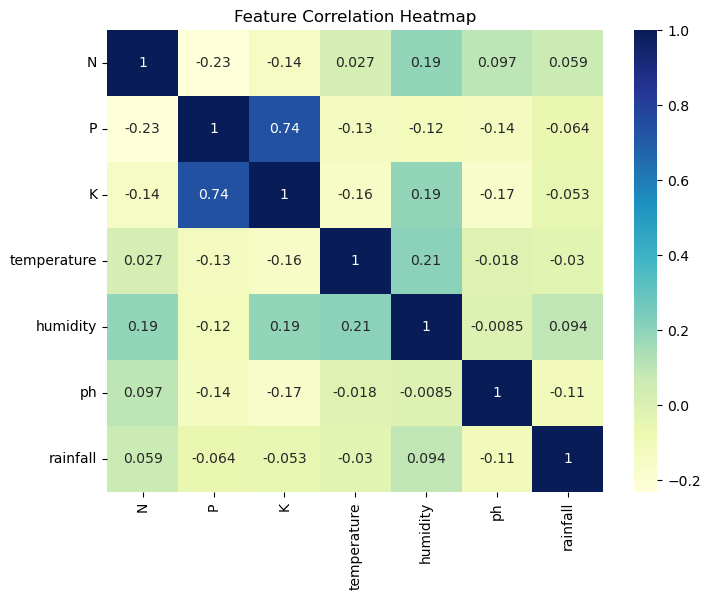

In [107]:
subset = crop_data.iloc[:, 0:7]
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(subset.corr(), annot=True, cmap='YlGnBu')
plt.title("Feature Correlation Heatmap")
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


In [13]:
class_data = crop_data.label

In [14]:
x_train,x_test,y_train,y_test = train_test_split(features_data,class_data,test_size = 0.2,random_state = 50)

In [15]:
x_train

,N,P,K,temperature,humidity,ph,rainfall
917,11,18,42,21.579369,94.882677,5.938529,102.859338
1722,61,64,52,43.302049,92.834054,6.641099,110.562229
380,32,79,15,23.909101,20.746193,5.706199,81.602112
1648,13,16,8,34.740049,93.123170,6.949839,100.196785
1258,21,139,201,19.364255,83.360940,5.980599,67.150947
...,...,...,...,...,...,...,...
2014,67,43,38,25.216227,70.882596,7.299305,195.864555
2157,115,31,30,24.229847,67.377684,6.840928,122.407342
1931,107,51,22,24.865608,78.220808,5.983076,79.568663
1504,20,129,201,23.410447,91.699133,5.587906,116.077793


In [16]:
x_test.head()

,N,P,K,temperature,humidity,ph,rainfall
349,9,80,19,21.806196,18.570866,5.945466,125.097269
1546,31,130,198,21.801298,92.734467,5.554824,120.058667
1746,35,66,47,31.701837,91.662322,6.953439,48.838106
1640,1,30,10,11.899257,91.346638,7.291406,103.577147
772,21,80,20,28.206673,68.270852,7.350870,64.328871


In [17]:
len(y_train)

1760

In [18]:
y_test.head()

349     kidneybeans
1546          apple
1746         papaya
1640         orange
772       blackgram
Name: label, dtype: category
Categories (22, object): ['apple', 'banana', 'blackgram', 'chickpea', ..., 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']

In [19]:
y_train.value_counts()

label
muskmelon      87
kidneybeans    86
banana         86
pomegranate    85
mungbean       85
maize          84
watermelon     83
orange         82
cotton         80
lentil         80
coffee         80
mango          79
coconut        78
pigeonpeas     78
blackgram      78
apple          78
chickpea       77
papaya         77
mothbeans      76
grapes         75
rice           75
jute           71
Name: count, dtype: int64

In [20]:
ros = RandomOverSampler(sampling_strategy = "minority")
x_ros_train,y_ros_train = ros.fit_resample(x_train,y_train) 

In [21]:
len(y_ros_train)

1776

In [22]:
y_ros_train.value_counts()

label
jute           87
muskmelon      87
banana         86
kidneybeans    86
pomegranate    85
mungbean       85
maize          84
watermelon     83
orange         82
cotton         80
lentil         80
coffee         80
mango          79
coconut        78
pigeonpeas     78
blackgram      78
apple          78
chickpea       77
papaya         77
mothbeans      76
grapes         75
rice           75
Name: count, dtype: int64

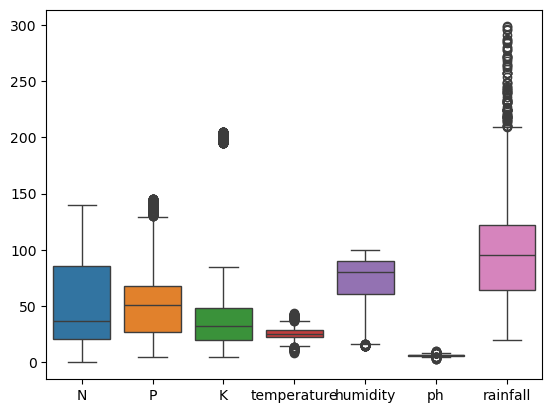

In [111]:
# Box plot finding outliers 
box = sns.boxplot(data = x_ros_train)
plt.savefig("box.png", dpi=300, bbox_inches='tight')

In [24]:
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(x_ros_train[features])
scaled_crop_data = pd.DataFrame(scaled_features,columns = features)

In [25]:
with open("crop_data_scale.pkl","wb") as f:
    pickle.dump(scaler,f)

In [26]:
scaled_features1 = scaler.transform(x_test[features])
scaled_crop_test_data = pd.DataFrame(scaled_features1,columns = features)

In [27]:
scaled_crop_data

,N,P,K,temperature,humidity,ph,rainfall
0,-1.081751,-1.062567,-0.108421,-0.802837,1.048603,-0.711187,-0.005576
1,0.262829,0.341676,0.093272,3.536373,0.956419,0.221524,0.134565
2,-0.517027,0.799581,-0.652992,-0.337462,-2.287378,-1.019622,-0.392314
3,-1.027968,-1.123621,-0.794177,1.826072,0.969429,0.631397,-0.054016
4,-0.812835,2.631202,3.098495,-1.245316,0.530150,-0.655336,-0.655227
...,...,...,...,...,...,...,...
1771,0.424179,0.219568,-0.189098,-0.159794,0.312785,0.913246,1.075564
1772,0.988903,-0.085703,-0.148760,0.006726,0.376733,0.766788,1.438947
1773,1.015794,-0.360446,-0.189098,-0.493402,0.139672,-0.171897,1.758748
1774,0.666203,0.036406,-0.047913,-0.260383,0.272259,-0.395106,1.488465


In [28]:
def objectve(trial):
    k = trial.suggest_int("k",1,11)
    w = trial.suggest_categorical("w",["uniform","distance"])
    knn = KNeighborsClassifier(n_neighbors = k,weights = w)
    values = cross_validate(estimator = knn,X = scaled_crop_data,y = y_ros_train,cv = 5,scoring = "accuracy",return_train_score = True)
    cv_score = values['test_score'].mean()
    train_score = values['train_score'].mean()
    trial.set_user_attr("train_score",train_score)
    return cv_score

In [29]:
space = {"k":range(1,11),"w":["uniform","distance"]}
study = optuna.create_study(direction = "maximize",sampler = RandomSampler())

[I 2025-06-16 14:33:22,707] A new study created in memory with name: no-name-f3c26b64-059f-457b-8be9-4bcc2b460de6


In [30]:
study.optimize(objectve,n_trials = 20)

[I 2025-06-16 14:33:22,934] Trial 0 finished with value: 0.9662177559740466 and parameters: {'k': 8, 'w': 'distance'}. Best is trial 0 with value: 0.9662177559740466.
[I 2025-06-16 14:33:23,127] Trial 1 finished with value: 0.9622772590599779 and parameters: {'k': 11, 'w': 'distance'}. Best is trial 0 with value: 0.9662177559740466.
[I 2025-06-16 14:33:23,833] Trial 2 finished with value: 0.9605871182149073 and parameters: {'k': 8, 'w': 'uniform'}. Best is trial 0 with value: 0.9662177559740466.
[I 2025-06-16 14:33:24,527] Trial 3 finished with value: 0.9538281373635069 and parameters: {'k': 10, 'w': 'uniform'}. Best is trial 0 with value: 0.9662177559740466.
[I 2025-06-16 14:33:25,205] Trial 4 finished with value: 0.9690362399113784 and parameters: {'k': 5, 'w': 'uniform'}. Best is trial 4 with value: 0.9690362399113784.
[I 2025-06-16 14:33:25,360] Trial 5 finished with value: 0.9735464472226617 and parameters: {'k': 4, 'w': 'distance'}. Best is trial 5 with value: 0.9735464472226617.

In [31]:
study.best_trial

FrozenTrial(number=5, state=1, values=[0.9735464472226617], datetime_start=datetime.datetime(2025, 6, 16, 14, 33, 25, 206516), datetime_complete=datetime.datetime(2025, 6, 16, 14, 33, 25, 359410), params={'k': 4, 'w': 'distance'}, user_attrs={'train_score': 1.0}, system_attrs={}, intermediate_values={}, distributions={'k': IntDistribution(high=11, log=False, low=1, step=1), 'w': CategoricalDistribution(choices=('uniform', 'distance'))}, trial_id=5, value=None)

In [32]:
study.best_params

{'k': 4, 'w': 'distance'}

In [33]:
knn1 = KNeighborsClassifier(n_neighbors=4, weights="distance")
model = knn1.fit(scaled_crop_data,y_ros_train)
class_pred = model.predict(scaled_crop_test_data)  # Assuming feature_test is 2D
acc = accuracy_score(y_test, class_pred)
print("Accuracy:", acc)

Accuracy: 0.9795454545454545


In [34]:
with open("crop_data_knn1.pkl","wb") as f:
     pickle.dump(knn1,f)

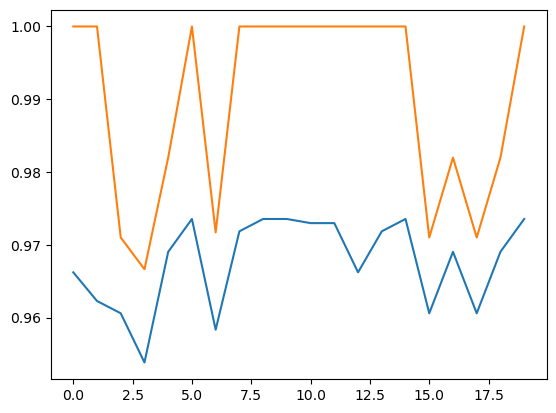

In [79]:
 plt.plot(study.trials_dataframe()["number"],study.trials_dataframe()["value"],label = "cv_acc")
plt.plot(study.trials_dataframe()["number"],study.trials_dataframe()["user_attrs_train_score"],label = "train_acc")
plt.show()

In [36]:
# tn,fp,fn,tp=confusion_matrix(y_test,class_pred).ravel()

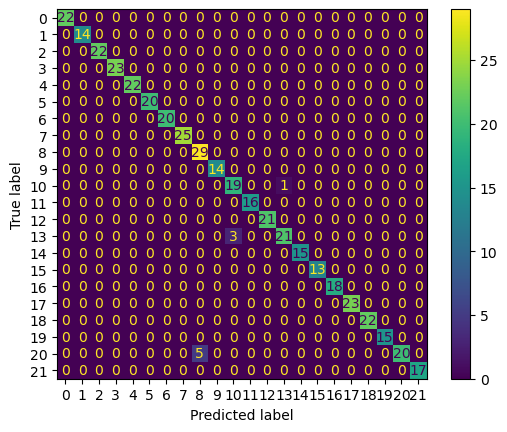

In [37]:
cm=ConfusionMatrixDisplay(confusion_matrix(y_test,class_pred))
cm.plot()
plt.show()

In [38]:
print(classification_report(y_test,class_pred))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        22
      banana       1.00      1.00      1.00        14
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        22
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        25
        jute       0.85      1.00      0.92        29
 kidneybeans       1.00      1.00      1.00        14
      lentil       0.86      0.95      0.90        20
       maize       1.00      1.00      1.00        16
       mango       1.00      1.00      1.00        21
   mothbeans       0.95      0.88      0.91        24
    mungbean       1.00      1.00      1.00        15
   muskmelon       1.00      1.00      1.00        13
      orange       1.00      1.00      1.00        18
      papaya       1.00    